In [1]:
import xarray as xr
import numpy as np
from pyowt.OpticalVariables import OpticalVariables
from pyowt.OWT import OWT
from pyowt.PlotOWT import PlotOV, PlotSpec
import pandas as pd

In [2]:
# load training data set
fn = "/Users/apple/GitHub/pyOWT/projects/zenodo/owt_BH2024_training_data_hyper.nc"
ds = xr.open_dataset(fn)
ds

<xarray.Dataset> Size: 2GB
Dimensions:     (ID: 100000, wavelen: 251)
Coordinates:
  * ID          (ID) int64 800kB 1 2 3 4 5 6 ... 99996 99997 99998 99999 100000
  * wavelen     (wavelen) int64 2kB 400 402 404 406 408 ... 892 894 896 898 900
Data variables: (12/20)
    ad          (ID, wavelen) float64 201MB ...
    agp         (ID, wavelen) float64 201MB ...
    aph         (ID, wavelen) float64 201MB ...
    aw          (ID, wavelen) float64 201MB ...
    bbp         (ID, wavelen) float64 201MB ...
    bp          (ID, wavelen) float64 201MB ...
    ...          ...
    A_d         (ID) float64 800kB ...
    G_d         (ID) float64 800kB ...
    Sal         (ID) float64 800kB ...
    Temp        (ID) float64 800kB ...
    a_frac      (ID) float64 800kB ...
    cocco_frac  (ID) float64 800kB ...
Attributes:
    description:  Training data for the OWT classification framework by Bi an...
    reference:    OWT framework: Bi, S., and Hieronymi, M. (2024). Holistic o...
    Author:       Shun Bi, Martin Hieronymi, Rüdiger Röttgers
    Creator:      Shun Bi, Shun.Bi@heren.de
    CreatedDate:  16/07/2024

In [4]:
# load old centoids data
# rename and save to the v01 folder...
fn = '/Users/apple/GitHub/pyOWT/pyowt/data/OWT_centroids.nc'
dc = xr.open_dataset(fn)

dc = dc.rename({'var': 'var1'})
if 'var' in dc.dims:
    dc = dc.rename({'var': 'var2'})

mean_old = dc['mean'].values
covm_old = dc['covm'].values
covm_old = np.transpose(covm_old, (1, 2, 0))
# mean_old.shape

dc_new = xr.Dataset(
    {
        "mean": (("type", "var1"), mean_old),
        "covm": (("var1", "var2", "type"), covm_old),
    },
    coords={
        "type": ["1", "2", "3a", "3b", "4a", "4b", "5a", "5b", "6", "7"],
        "var1": ["AVW", "ABC", "NDI"],
        "var2": ["AVW", "ABC", "NDI"]
    },

)

dc_new["mean"].attrs["long_name"] = "Mean matrix of three optical variables for ten types. Shape (10, 3)"
dc_new["mean"].attrs["units"] = "unitless"

dc_new["covm"].attrs["long_name"] = "Covariance matrix of three optical variables for ten types. Shape (3, 3, 10)"
dc_new["covm"].attrs["units"] = "unitless"


dc_new.attrs['Description'] = 'Centroids and covariance matrix data for the optical water type classification by Bi and Hieronymi (2024)'
dc_new.attrs['Version'] = 'v01'
dc_new.attrs['Author'] = 'Shun Bi'
dc_new.attrs['Email'] = 'Shun.Bi@outlook.com'
dc_new.attrs['CreateDate'] = '2023-09-26'
dc_new.attrs['lamBC'] = dc['lamBC'].values.item()
dc_new.attrs['lamBC_description'] = 'Lambda coefficient for Box-Cox transformation for Area'
dc_new.attrs['TypeName'] = '1, 2, 3a, 3b, 4a, 4b, 5a, 5b, 6, 7'
dc_new.attrs['TypeColorName'] = 'blue, yellow, orange, cyan, green, purple, darkblue, red, chocolate, darkcyan'
dc_new.attrs['TypeColorHex'] = '#0000FF, #FFFF00, #FFA500, #00FFFF, #00FF00, #A020F0, #00008B, #FF0000, #D2691E, #008B8B'
dc_new.attrs['Reference'] = 'Bi, S., and Hieronymi, M. (2024). Holistic optical water type classification for ocean, coastal, and inland waters. Limnology & Oceanography, lno.12606. doi: 10.1002/lno.12606'

dc_new.to_netcdf("/Users/apple/GitHub/pyOWT/pyowt/data/v01/OWT_centroids.nc")

/Users/apple/GitHub/pyOWT/.venv/lib/python3.12/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'var'} appear more than once in dims=('typ', 'var', 'var'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.warn(
/Users/apple/GitHub/pyOWT/.venv/lib/python3.12/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'var1'} appear more than once in dims=('typ', 'var1', 'var1'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is l

In [6]:
# fetch data from the training set and do the classification
wavelen = ds['wavelen'].values
Rrs = ds['Rrs'].values
type_set = ds['type'].values

ov = OpticalVariables(Rrs, wavelen)
owt = OWT(ov.AVW, ov.Area, ov.NDI, version='v01')

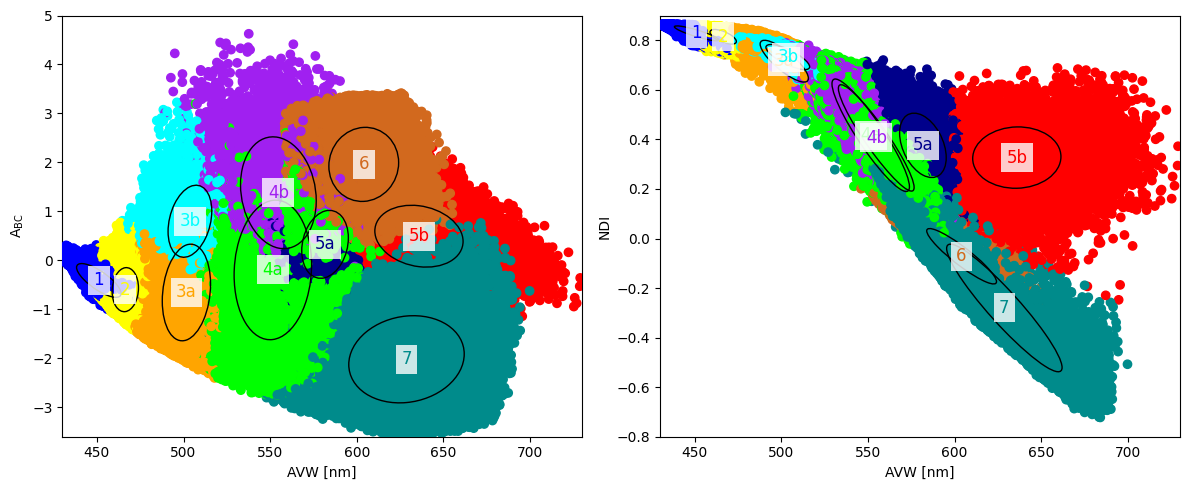

In [14]:
# visualize the classification result 
PlotOV(owt)
# PlotSpec(owt, ov)

In [8]:
# find the same types returned
type_new = owt.type_str
type_new = type_new.reshape(type_new.shape[0])

ind_same_type = np.where(type_new == type_set)[0]
ind_same_type

# calculate new covm and centoids (?) from new type results
ov_mat = np.hstack((owt.AVW, owt.ABC, owt.NDI))[ind_same_type,:]
type_used = type_new[ind_same_type]

unique_types = np.sort(np.unique(type_used))

# keep the same data structure
# - mean: (N, 3)
# - covm: (3, 3, N)
dc = xr.open_dataset("/Users/apple/GitHub/pyOWT/pyowt/data/v01/OWT_centroids.nc")
lamBC = dc.attrs['lamBC']
mean_new = np.zeros_like(dc['mean'].values)
covm_new = np.zeros_like(dc['covm'].values)

for i, t in enumerate(unique_types): 
    indices = np.where(type_used == t)[0]
    samples = ov_mat[indices, :]

    mean_type = np.mean(samples, axis=0)
    covm_type = np.cov(samples, rowvar=False)

    mean_new[i, :] = mean_type
    covm_new[:, :, i] = covm_type

# save to new centroid version folder

dc_new = xr.Dataset(
    {
        "mean": (("type", "var1"), mean_new),
        "covm": (("var1", "var2", "type"), covm_new),
    },
    coords={
        "type": ["1", "2", "3a", "3b", "4a", "4b", "5a", "5b", "6", "7"],
        "var1": ["AVW", "ABC", "NDI"],
        "var2": ["AVW", "ABC", "NDI"]
    },

)

dc_new["mean"].attrs["long_name"] = "Mean matrix of three optical variables for ten types. Shape (10, 3)"
dc_new["mean"].attrs["units"] = "unitless"

dc_new["covm"].attrs["long_name"] = "Covariance matrix of three optical variables for ten types. Shape (3, 3, 10)"
dc_new["covm"].attrs["units"] = "unitless"

dc_new.attrs['Description'] = 'Centroids and covariance matrix data for the optical water type classification by Bi and Hieronymi (2024)'
dc_new.attrs['Version'] = 'v02'
dc_new.attrs['VersionLog'] = 'Covariance matrix has been shrinked based on the original training data results.'
dc_new.attrs['Author'] = 'Shun Bi'
dc_new.attrs['Email'] = 'Shun.Bi@outlook.com'
dc_new.attrs['CreateDate'] = '2024-10-21'
dc_new.attrs['lamBC'] = lamBC
dc_new.attrs['lamBC_description'] = 'Lambda coefficient for Box-Cox transformation for Area'
dc_new.attrs['TypeName'] = '1, 2, 3a, 3b, 4a, 4b, 5a, 5b, 6, 7'
dc_new.attrs['TypeColorName'] = 'blue, yellow, orange, cyan, green, purple, darkblue, red, chocolate, darkcyan'
dc_new.attrs['TypeColorHex'] = '#0000FF, #FFFF00, #FFA500, #00FFFF, #00FF00, #A020F0, #00008B, #FF0000, #D2691E, #008B8B'
dc_new.attrs['Reference'] = 'Bi, S., and Hieronymi, M. (2024). Holistic optical water type classification for ocean, coastal, and inland waters. Limnology & Oceanography, lno.12606. doi: 10.1002/lno.12606'

dc_new.to_netcdf("/Users/apple/GitHub/pyOWT/pyowt/data/v02/OWT_centroids.nc")

# Update OWT_mean_spec.csv for plotting

In [9]:
# for old version 01
# - taking Rrs from netcddf file
# - taking type_set and ABC as well
# load training data set
fn = "/Users/apple/GitHub/pyOWT/projects/zenodo/owt_BH2024_training_data_hyper.nc"
ds = xr.open_dataset(fn)

wavelen = ds['wavelen'].values
Rrs = ds['Rrs'].values
type_set = ds['type'].values
Area = owt.Area

In [10]:
results = []

for t in unique_types:

    indices = np.where(type_set == t)[0]
    Rrs_samples = Rrs[indices, :]
    ABC_samples = Area[indices, 0]
    m_Rrs_t = np.mean(Rrs_samples, axis=0)
    sd_Rrs_t = np.std(Rrs_samples, axis=0)
    lo_Rrs_t = np.quantile(Rrs_samples, 0.05, axis=0)
    up_Rrs_t = np.quantile(Rrs_samples, 0.95, axis=0)

    nRrs_samples = Rrs_samples / ABC_samples[:, np.newaxis]

    m_nRrs_t = np.mean(nRrs_samples, axis=0)
    sd_nRrs_t = np.std(nRrs_samples, axis=0)
    lo_nRrs_t = np.quantile(nRrs_samples, 0.05, axis=0)
    up_nRrs_t = np.quantile(nRrs_samples, 0.95, axis=0)

    for i in range(len(wavelen)):
        results.append([
            t, 
            wavelen[i],
            m_Rrs_t[i],
            sd_Rrs_t[i],
            lo_Rrs_t[i],
            up_Rrs_t[i],
            m_nRrs_t[i],
            sd_nRrs_t[i],
            lo_nRrs_t[i],
            up_nRrs_t[i]
        ])

columns = ["type", "wavelen", "m_Rrs", "sd_Rrs", "lo_Rrs", "up_Rrs", "m_nRrs", "sd_nRrs", "lo_nRrs", "up_nRrs"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("/Users/apple/GitHub/pyOWT/pyowt/data/v01/OWT_mean_spec.csv", index=False)

In [11]:
type_used = type_new[ind_same_type]
Rrs_used = Rrs[ind_same_type, :]
Area_used = Area[ind_same_type, :]

unique_types = np.sort(np.unique(type_used))

results = []

for t in unique_types:

    indices = np.where(type_used == t)[0]
    Rrs_samples = Rrs_used[indices, :]
    ABC_samples = Area_used[indices, 0]

    m_Rrs_t = np.mean(Rrs_samples, axis=0)
    sd_Rrs_t = np.std(Rrs_samples, axis=0)
    lo_Rrs_t = np.quantile(Rrs_samples, 0.05, axis=0)
    up_Rrs_t = np.quantile(Rrs_samples, 0.95, axis=0)

    nRrs_samples = Rrs_samples / ABC_samples[:, np.newaxis]

    m_nRrs_t = np.mean(nRrs_samples, axis=0)
    sd_nRrs_t = np.std(nRrs_samples, axis=0)
    lo_nRrs_t = np.quantile(nRrs_samples, 0.05, axis=0)
    up_nRrs_t = np.quantile(nRrs_samples, 0.95, axis=0)

    for i in range(len(wavelen)):
        results.append([
            t, 
            wavelen[i],
            m_Rrs_t[i],
            sd_Rrs_t[i],
            lo_Rrs_t[i],
            up_Rrs_t[i],
            m_nRrs_t[i],
            sd_nRrs_t[i],
            lo_nRrs_t[i],
            up_nRrs_t[i]
        ])

columns = ["type", "wavelen", "m_Rrs", "sd_Rrs", "lo_Rrs", "up_Rrs", "m_nRrs", "sd_nRrs", "lo_nRrs", "up_nRrs"]
df = pd.DataFrame(results, columns=columns)
df.to_csv("/Users/apple/GitHub/pyOWT/pyowt/data/v02/OWT_mean_spec.csv", index=False)

# check differences

In [134]:
import seaborn as sns
import matplotlib.pyplot as plt

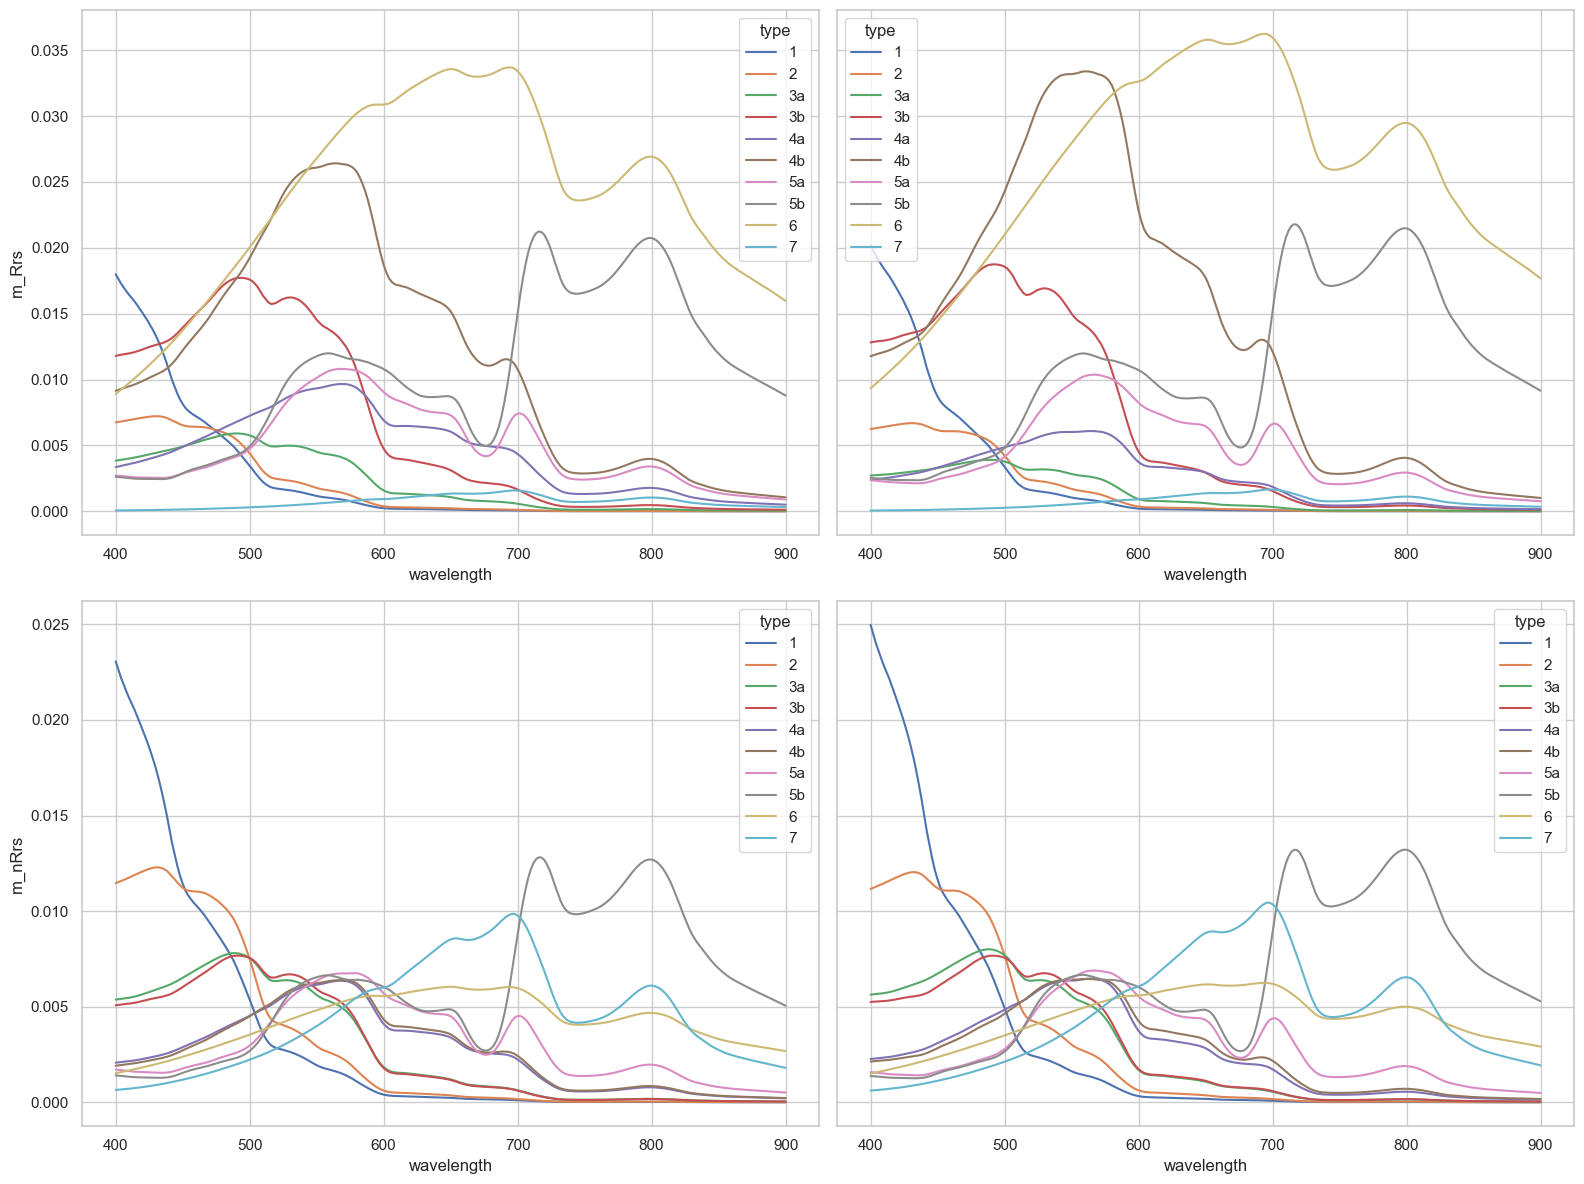

In [143]:
d1 = pd.read_csv('/Users/apple/GitHub/pyOWT/pyowt/data/v01/OWT_mean_spec.csv')
d2 = pd.read_csv('/Users/apple/GitHub/pyOWT/pyowt/data/v02/OWT_mean_spec.csv')

sns.set(style='whitegrid')

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharey='row')

sns.lineplot(ax=axes[0, 0], data=d1, x='wavelength', y='m_Rrs', hue='type')
sns.lineplot(ax=axes[0, 1], data=d2, x='wavelength', y='m_Rrs', hue='type')
sns.lineplot(ax=axes[1, 0], data=d1, x='wavelength', y='m_nRrs', hue='type')
sns.lineplot(ax=axes[1, 1], data=d2, x='wavelength', y='m_nRrs', hue='type')

plt.tight_layout()
plt.show()

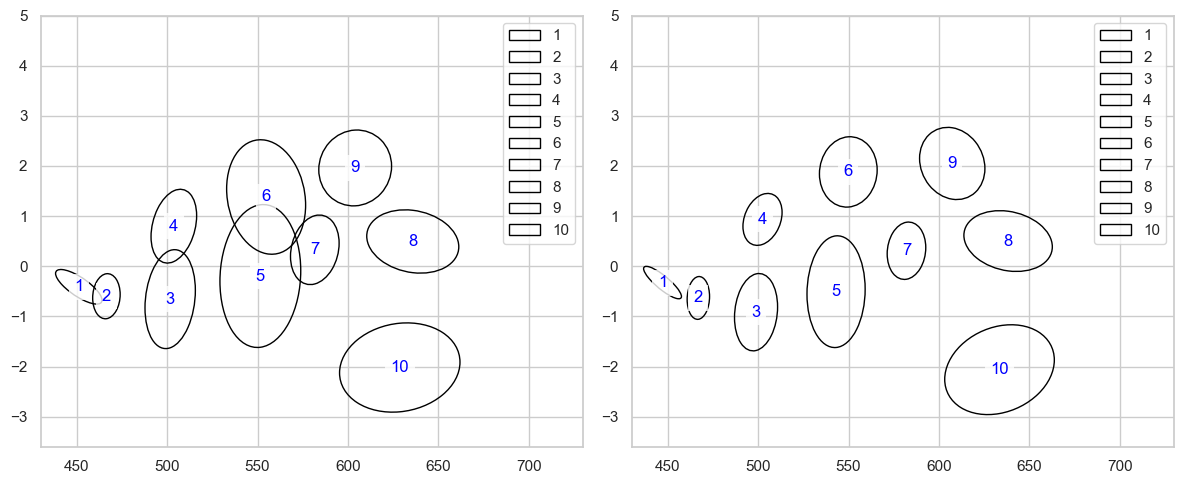

In [178]:
import matplotlib.pyplot as plt

d1 = xr.open_dataset("/Users/apple/GitHub/pyOWT/pyowt/data/v01/OWT_centroids.nc")
d2 = xr.open_dataset("/Users/apple/GitHub/pyOWT/pyowt/data/v02/OWT_centroids.nc")

mean1 = d1['mean'].values
covm1 = d1['covm'].values
mean2 = d2['mean'].values
covm2 = d2['covm'].values

AVW_MIN = 430
AVW_MAX = 730
ABC_MIN = -3.6
ABC_MAX = 5
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
axs[0].set_xlim(AVW_MIN, AVW_MAX)
axs[0].set_ylim(ABC_MIN, ABC_MAX)
for i in range(mean1.shape[0]):
    PlotOV.draw_ellipse(axs[0], mean1[i,0], mean1[i,1], covm1[:2,:2,i], color='blue', label=f"{i+1}")

axs[1].set_xlim(AVW_MIN, AVW_MAX)
axs[1].set_ylim(ABC_MIN, ABC_MAX)
for i in range(mean2.shape[0]):
    PlotOV.draw_ellipse(axs[1], mean2[i,0], mean2[i,1], covm2[:2,:2,i], color='blue', label=f"{i+1}")

axs[0].legend()
axs[1].legend()
plt.tight_layout()
plt.show()

In [179]:
version = 'v02'
f"data/{version}/OWT_centroids.nc"

'data/v02/OWT_centroids.nc'